In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 

from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%load_ext autoreload
%autoreload 2

### 1. Read wheat and weather data

In [2]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather = pd.read_csv("data/features/era_features.csv")

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv = x_y_cv.loc[x_y_cv["year"] < 2017].reset_index(drop=True) # Leave test set aside
x_y_cv = x_y_cv.loc[:, [c for c in x_y_cv.columns if ("_8" not in c)]]

### 2. Detrend national wheat yield
.. using all previous years to estimate the slope (data since 69 is available)

#### 2.1 Estimate slope and bias for each year's trend correction

In [3]:
# dictionary that stores for each year the slope and bias estimated from the previous years
years_to_params = {}
# iterate over all years in x_y_cv dataset (1993-2016)
for year in x_y_cv["year"].unique().tolist():
    # initialize key
    years_to_params[year] = {"slope":np.nan, "bias":np.nan}
    # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
    year_range = wheat.loc[wheat["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
    slope, bias= np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias
# print example
years_to_params[2010]

{'slope': 40.186997705965986, 'bias': -77958.053590407}

#### 2.2 Predict yield level for each year based on trend function

.. and visualize the trend estimates compared to observed yield

379.99


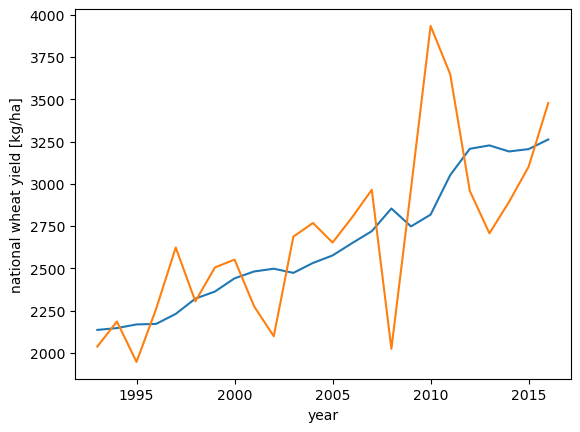

In [4]:
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)
    
plt.plot(x_y_cv["year"].unique().tolist(), trend_estimated)
plt.plot(x_y_cv["year"].unique().tolist(), x_y_cv["yield [kg/ha]"])
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))
plt.show()

#### 2.3. Adjust the trend using multiplicative decomposition

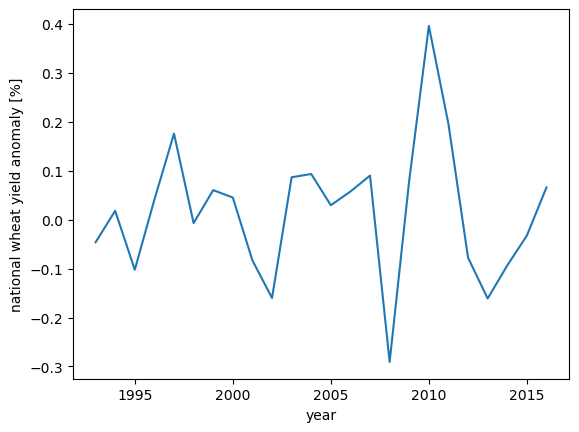

In [5]:
x_y_cv["yield_trend [kg/ha]"] = trend_estimated
x_y_cv["yield anomaly [%]"] = (x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"])/x_y_cv["yield_trend [kg/ha]"]

plt.plot(x_y_cv["year"], x_y_cv["yield anomaly [%]"]);
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.show()

### 3. Identify relevant locations for weather features

- there are more than 100 municipalities with tmean and rainfall data
- we perform LOYO-CV to select the municipalities that best explain national wheat yield

In [6]:
# obtain the municipalities from the column name; santa fe san cristobal to replace NANs
municipalities = list(set([c.split("_")[1] if c not in ['year', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]'] else 'santa fe san cristobal' for c in x_y_cv.columns]))

In [134]:
for m in municipalities:
    for no_of_features in list(range(1,5)):
        
        # filter by current municipality
        x_y_cv_temp = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] == m] + ["yield anomaly [%]"]]
        
        # feature-target split
        X = x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if ("rain" in c) or ("tmean" in c)]]
        y = x_y_cv_temp["yield anomaly [%]"]
        X_columns = X.columns
        
        # scale features
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)
        
        # store features and target in variables for better readability
        X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
        X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
        
        # basis expansion to linear model
        X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9", "tt_10", "tt_11"])
        X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9", "rr_10", "rr_11"])
        X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9", "rt_10", "rt_11"])
        
        # merge to feature dataframe
        X = (X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True))
        
        # remove correlated features
        cor_matrix = X.corr().abs().round(2)
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
        X = X.drop(to_drop, axis=1)
        
        #for i in range(0,X.shape[1]):
        #    print(pearsonr(np.array(X).transpose()[i], y)[0])
        #    print(X.columns[i])
        
        # pipeline object for regression model
        pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
        
        # Perform LOOCV and obtain predictions
        loo = LeaveOneOut()
        y_pred = cross_val_predict(pipeline, X, y, cv=loo)

        # Calculate metrics
        rmse = np.round(100*mse(y_pred, y, squared=False), 1)
        meanabserr = np.round(100*mae(y_pred, y), 1)
        r = np.round(pearsonr(y_pred, y)[0], 2)

        # print metrics if they are good
        if r > 0.5:
            print("rmse is {}, MAE is {}, and pearson's r is {} for area {} with {} features".format(rmse, meanabserr, r, m, no_of_features))

rmse is 11.8, MAE is 9.2, and pearson's r is 0.52 for area buenos aires bahia blanca with 1 features
rmse is 11.1, MAE is 8.3, and pearson's r is 0.57 for area buenos aires bahia blanca with 4 features
rmse is 11.5, MAE is 9.0, and pearson's r is 0.53 for area buenos aires coronel pringles with 1 features
rmse is 10.8, MAE is 9.0, and pearson's r is 0.6 for area buenos aires hipolito yrigoyen with 1 features
rmse is 12.1, MAE is 8.9, and pearson's r is 0.53 for area buenos aires coronel dorrego with 1 features
rmse is 11.4, MAE is 8.6, and pearson's r is 0.54 for area buenos aires coronel suarez with 1 features
rmse is 11.6, MAE is 8.7, and pearson's r is 0.52 for area buenos aires coronel suarez with 2 features
rmse is 11.6, MAE is 8.7, and pearson's r is 0.54 for area santa fe san justo with 4 features
rmse is 11.5, MAE is 8.8, and pearson's r is 0.52 for area buenos aires saavedra with 1 features
rmse is 11.6, MAE is 9.0, and pearson's r is 0.51 for area buenos aires saavedra with 2

**The best performance comes from buenos aires - [bahia blanca, coronel pringles, hipolito yrigoyen, coronel dorrego, coronel suarez, saavedra] and santa fe san justo**


### 4. Filter features 

.. to come only from buenos aires coronel dorrego and hipolpito yrigoyen

In [7]:
selected_areas = ["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"]
x_y_cv_filtered = (x_y_cv
                   .loc[:, 
                        [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] in selected_areas] + ["yield anomaly [%]", "yield [kg/ha]", "year"]])

x_y_cv_filtered.columns = [c.replace("buenos aires ", "") if "buenos aires" in c else c for c in x_y_cv_filtered.columns]
x_y_cv_filtered.head()

,rain_bahia blanca_9,rain_bahia blanca_10,rain_bahia blanca_11,rain_coronel dorrego_9,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel pringles_9,rain_coronel pringles_10,rain_coronel pringles_11,rain_coronel suarez_9,...,tmean_hipolito yrigoyen_11,tmean_saavedra_9,tmean_saavedra_10,tmean_saavedra_11,tmean_santa fe san justo_9,tmean_santa fe san justo_10,tmean_santa fe san justo_11,yield anomaly [%],yield [kg/ha],year
0,0.000719,0.002106,0.003066,0.000629,0.001886,0.002961,0.001025,0.001977,0.003917,0.001568,...,17.662613,10.539790,14.453463,15.948329,15.597872,19.565541,20.987172,-0.046171,2037.439151,1993
1,0.000796,0.001501,0.001297,0.000819,0.001880,0.001744,0.000643,0.002184,0.001526,0.000750,...,19.764100,11.147357,13.039605,18.724908,17.975140,19.196191,21.844978,0.018138,2185.741998,1994
2,0.000292,0.002034,0.002415,0.000536,0.002009,0.003304,0.000376,0.001977,0.004888,0.000343,...,19.738954,11.834382,13.959151,18.111659,17.465513,18.616602,23.485742,-0.102265,1946.759707,1995
3,0.000662,0.002690,0.003121,0.000632,0.003675,0.003039,0.000570,0.004113,0.003204,0.000635,...,19.933778,10.670339,15.087087,18.174252,16.210073,20.117578,22.955329,0.040968,2260.470320,1996
4,0.001522,0.002799,0.001475,0.001325,0.003286,0.002113,0.001163,0.003790,0.002169,0.001424,...,17.689280,9.895978,13.221114,16.266609,18.553509,20.192111,22.493659,0.175913,2623.252920,1997


### 5. Train national model

In [8]:
# feature-target split
X = x_y_cv_filtered.loc[:, [c for c in x_y_cv_filtered.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv_filtered["yield anomaly [%]"]
X_columns = X.columns

# scale features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

# store features and target in variables for better readability
X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]

# basis expansion to linear model
#X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a"])
#X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a"])
#X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a"])

#X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b"])
#X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b"])
#X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b"])

#X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b", "tt_9_c", "tt_10_c", "tt_11_c"])
#X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b",  "rr_9_c", "rr_10_c", "rr_11_c"])
#X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b", "rt_9_c", "rt_10_c", "rt_11_c"])

#X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b", "tt_9_c", "tt_10_c", "tt_11_c", "tt_9_d", "tt_10_d", "tt_11_d"])
#X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b",  "rr_9_c", "rr_10_c", "rr_11_c",  "rr_9_d", "rr_10_d", "rr_11_d"])
#X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b", "rt_9_c", "rt_10_c", "rt_11_c", "rt_9_d", "rt_10_d", "rt_11_d"])

X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b", "tt_9_c", "tt_10_c", "tt_11_c", 
                                                                               "tt_9_d", "tt_10_d", "tt_11_d", "tt_9_e", "tt_10_e", "tt_11_e", "tt_9_f", "tt_10_f", "tt_11_f", "tt_9_g", "tt_10_g", "tt_11_g",])
X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b",  "rr_9_c", "rr_10_c", "rr_11_c",  "rr_9_d", "rr_10_d", "rr_11_d",
                                                                              "rr_9_e", "rr_10_e", "rr_11_e", "rr_9_f", "rr_10_f", "rr_11_f", "rr_9_g", "rr_10_g", "rr_11_g"])
X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b", "rt_9_c", "rt_10_c", "rt_11_c",
                                                                                            "rt_9_d", "rt_10_d", "rt_11_d", "rt_9_e", "rt_10_e", "rt_11_e", "rt_9_f", "rt_10_f", "rt_11_f", "rt_9_g", "rt_10_g", "rt_11_g"])

# merge to feature dataframe
X = (X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True))

# remove correlated features
cor_matrix = X.corr().abs().round(2)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
X = X.drop(to_drop, axis=1)

VIF = add_constant(X)
pd.Series([variance_inflation_factor(VIF.values, i) 
               for i in range(VIF.shape[1])], 
              index=VIF.columns)

const      8.992715
tt_9_a     1.617312
tt_10_a    1.459719
tt_11_a    1.385829
tt_9_g     1.165063
tt_10_g    1.210382
rr_9_a     1.151485
rr_11_a    1.280214
rr_9_e     1.181543
rr_10_e    1.140614
rr_10_g    1.127330
rr_11_g    1.382220
dtype: float64

In [9]:
#for i in range(0, X.shape[1]):
#    print("{}: {}".format(X.columns[i], np.round(pearsonr(np.array(X).transpose()[i], y)[0], 2)))
    
# pipeline object for regression model
pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=3)), ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)
for idx,estimator in enumerate(output['estimator']):
    print(estimator.named_steps["selector"].get_feature_names_out(X.columns))

['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_10_g' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']


rmse is 0.0838, MAE is 0.0656, and pearson's r is 0.79


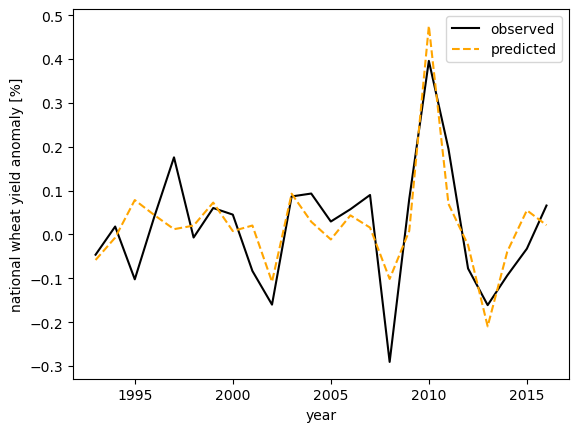

In [10]:
# Calculate metrics
rmse = np.round(mse(y, y_pred, squared=False), 4)
meanabserr = np.round(mae(y, y_pred), 4)
r = np.round(pearsonr(y, y_pred)[0], 2)

print("rmse is {}, MAE is {}, and pearson's r is {}".format(rmse, meanabserr, r))

plt.plot(x_y_cv_filtered["year"], y, color="black", label="observed");
plt.plot(x_y_cv_filtered["year"], y_pred, linestyle="dashed", color="orange", label="predicted");
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.legend();

The hindcast data needs bias-adjustment for the chosen locations, hence we store a filtered ERA5 for later use:

In [11]:
era_preprocessed = pd.read_csv("data/ERA5/era5_preprocessed.csv")
era_preprocessed = era_preprocessed.loc[era_preprocessed["name"].isin(["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"])].reset_index(drop=True)

era_preprocessed.to_csv("nmme/data/era_filtered_locations_v2.csv", index=False)
era_preprocessed.to_csv("c3s/data/era_filtered_locations_v2.csv", index=False)
era_preprocessed.to_csv("clik-apcc/data/era_filtered_locations_v2.csv", index=False)

### 6. Express as absolute yield forecast

.. by applying the inverse of the yield correction to the yield anomaly estimations

8.55


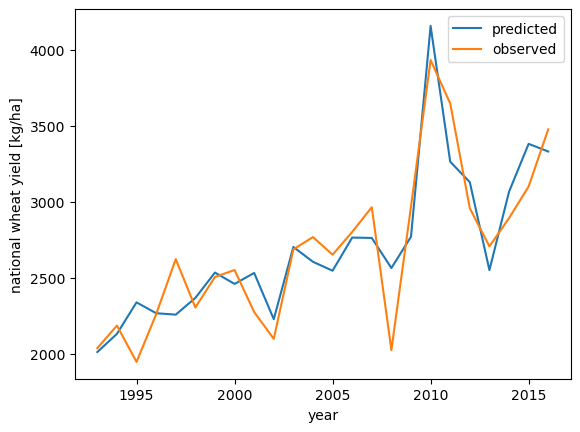

In [12]:
z = x_y_cv_filtered["year"].apply(lambda x: years_to_params[x]["slope"] * x + years_to_params[x]["bias"])

plt.plot(x_y_cv_filtered["year"], y_pred * z + z, label="predicted");
plt.plot(x_y_cv_filtered["year"], x_y_cv_filtered["yield [kg/ha]"], label="observed");
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")
plt.legend();

print(np.round(100 * np.mean(mse(y_pred * z + z, x_y_cv_filtered["yield [kg/ha]"], squared=False)/x_y_cv_filtered["yield [kg/ha]"]), 2))

In [13]:
x_y_cv_filtered = x_y_cv_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield [kg/ha]", "yield anomaly [%]"]).reset_index(drop=False)

In [14]:
x_y_cv_filtered.head()

,model,year,init_month,yield [kg/ha],yield anomaly [%],rain_bahia blanca_9,rain_bahia blanca_10,rain_bahia blanca_11,rain_coronel dorrego_9,rain_coronel dorrego_10,...,tmean_coronel suarez_11,tmean_hipolito yrigoyen_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_saavedra_9,tmean_saavedra_10,tmean_saavedra_11,tmean_santa fe san justo_9,tmean_santa fe san justo_10,tmean_santa fe san justo_11
0,ERA,1993,12,2037.439151,-0.046171,0.000719,0.002106,0.003066,0.000629,0.001886,...,16.009900,11.611024,16.041256,17.662613,10.539790,14.453463,15.948329,15.597872,19.565541,20.987172
1,ERA,1994,12,2185.741998,0.018138,0.000796,0.001501,0.001297,0.000819,0.001880,...,18.558844,12.882020,14.715967,19.764100,11.147357,13.039605,18.724908,17.975140,19.196191,21.844978
2,ERA,1995,12,1946.759707,-0.102265,0.000292,0.002034,0.002415,0.000536,0.002009,...,17.831665,13.288871,15.503959,19.738954,11.834382,13.959151,18.111659,17.465513,18.616602,23.485742
3,ERA,1996,12,2260.470320,0.040968,0.000662,0.002690,0.003121,0.000632,0.003675,...,18.058169,12.625015,16.642875,19.933778,10.670339,15.087087,18.174252,16.210073,20.117578,22.955329
4,ERA,1997,12,2623.252920,0.175913,0.001522,0.002799,0.001475,0.001325,0.003286,...,16.206354,11.807031,14.851108,17.689280,9.895978,13.221114,16.266609,18.553509,20.192111,22.493659


### 7. Export datasets

In [15]:
x_y_cv_filtered.to_csv("data/features/era_features_and_target_v2.csv", index=False)